# Problem 1: Perceptron

## Part (a)

Look for a hyperplane that correctly classifies all points with their corresponding labels without any error. The perceptron algorithm will converge if the dataset is linearly separable.

- Start with the weight vector $\mathbf{w}_1 = [4, 0]$ (from the first sample).
- Iterate through each sample, making adjustments if the prediction is incorrect.

Prediction rule:
$$
\text{prediction} = \begin{cases} 
  1 & \text{if } \mathbf{w}^\top \mathbf{x} \geq 0 \\
  -1 & \text{otherwise} 
\end{cases}
$$

- **Convergence**: The perceptron algorithm will converge to a solution if the dataset is linearly separable. Since we handle all samples only once, convergence within a single pass is unlikely unless the initial weight vector is already very close to the optimal.

- **Linear Separability**: If we run the algorithm and it fails to classify without errors after several iterations, the data may not be linearly separable.

Therefore, if we run the algo multiple times and consistently find that some points remain misclassified, it hints that the data is not linearly separable.

## Part (b)

Calculate the weight updates based on the initial weight vector $\mathbf{w}_1 = [4, 0]$:

1. **Sample 1**: $\mathbf{x}_1 = [4, 0]$, $y_1 = 1$
   - Prediction: $4 \times 4 + 0 \times 0 = 16$ (predict 1)
   - Correct classification, no update.

2. **Sample 2**: $\mathbf{x}_2 = [1, 1]$, $y_2 = -1$
   - Prediction: $4 \times 1 + 0 \times 1 = 4$ (predict 1)
   - Incorrect, update $\mathbf{w} = \mathbf{w} - \mathbf{x}_2 = [4, 0] - [1, 1] = [3, -1]$

and so on...

In [3]:
import numpy as np

X = np.array([[4, 0], [1, 1], [0, 1], [-2, -2], [-2, 1], [1, 0], [5, 2], [3, 0]])
y = np.array([1, -1, -1, 1, -1, 1, -1, -1])

# initial weight vector (i.e. first sample)
w = np.array([4, 0])

# predict label based on the weight vector
def predict(x):
    return np.sign(np.dot(w, x))

# perceptron update rule
for x, label in zip(X, y):
    prediction = predict(x)
    if prediction == 0:  # treat zero as a positive prediction (+1)
        prediction = 1
    if prediction != label:
        w = w + label * x

print("final weight vector:", w)


final weight vector: [-2 -3]


## Part (c)

### Standard Perceptron
- Weight vector $\mathbf{w}$ updated from part (b).
- Prediction function: $\hat{y} = \text{sign}(\mathbf{w}^\top \mathbf{x})$

### Voted Perceptron
- Maintains a set of weight vectors and counts (votes).
- Prediction function aggregates over all weights: $\hat{y} = \text{sign}(\sum_{i} c_i \cdot \text{sign}(\mathbf{w}_i^\top \mathbf{x}))$

### Average Perceptron
- Averages weight vectors over all updates.
- Prediction function: $\hat{y} = \text{sign}(\bar{\mathbf{w}}^\top \mathbf{x})$, where $\bar{\mathbf{w}}$ is the average of all weight vectors up to current time step.

In [11]:
# func for standard perceptron prediction
def standard_perceptron_predict(x, w):
    return np.sign(np.dot(w, x))

# voted perceptron - assume we only collect votes during the main training loop
voted_w = []
voted_c = []

def voted_perceptron_train(X, y, w):
    c = 1
    for x, label in zip(X, y):
        prediction = np.sign(np.dot(w, x))
        if prediction == 0:
            prediction = 1
        if prediction != label:
            voted_w.append(w.copy())
            voted_c.append(c)
            w = w + label * x
            c = 1
        else:
            c += 1
    voted_w.append(w.copy())  # append the last weight vector and count
    voted_c.append(c)

def voted_perceptron_predict(x):
    return np.sign(sum(c * np.sign(np.dot(w, x)) for w, c in zip(voted_w, voted_c)))

# average perceptron
average_w = np.zeros_like(X[0])
counter = 0

def average_perceptron_train(X, y, w):
    global average_w, counter
    for x, label in zip(X, y):
        prediction = np.sign(np.dot(w, x))
        if prediction == 0:
            prediction = 1
        if prediction != label:
            w = w + label * x
        average_w += w
        counter += 1

def average_perceptron_predict(x):
    return np.sign(np.dot(average_w / counter, x))

# training all perceptrons
w = np.array([4, 0])  # re-initialize w for fairness in training
voted_perceptron_train(X, y, w.copy())
average_perceptron_train(X, y, w.copy())

print("voted perceptron final weights and counts:", list(zip(voted_w, voted_c)))
print("average perceptron final averaged weights:", average_w / counter)


voted perceptron final weights and counts: [(array([4, 0]), 2), (array([ 3, -1]), 2), (array([ 1, -3]), 4), (array([-2, -3]), 1)]
average perceptron final averaged weights: [ 1.5   -2.125]


## Part (d)

In [13]:
# error calc for each perceptron type
def calculate_errors(X, y, predict_function):
    errors = 0
    for x, label in zip(X, y):
        prediction = predict_function(x)
        if prediction == 0:  # handle zero as positive
            prediction = 1
        if prediction != label:
            errors += 1
    return errors

standard_errors = calculate_errors(X, y, lambda x: standard_perceptron_predict(x, w))
voted_errors = calculate_errors(X, y, voted_perceptron_predict)
average_errors = calculate_errors(X, y, average_perceptron_predict)

print(f"standard perceptron errors: {standard_errors}")
print(f"voted perceptron errors: {voted_errors}")
print(f"average perceptron errors: {average_errors}")


standard perceptron errors: 5
voted perceptron errors: 1
average perceptron errors: 2


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
from utils import mnist_reader
from utils.data_load import load
import codes
# Load matplotlib images inline
%matplotlib inline
# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Problem 2: Modified Logistic Regression with Alt Labels

## Part (a)

The logistic function $h_w(x)$ is given by:

$$
h_w(x) = \frac{1}{1 + e^{-w^\top x}}
$$

We need to show that the hyperbolic tangent function $\text{tanh}(w^\top x)$ can be expressed as $2h_{w'}(x) - 1$ with $w' = 2w$. The $\text{tanh}$ function is defined as:

$$
\text{tanh}(w^\top x) = \frac{e^{w^\top x} - e^{-w^\top x}}{e^{w^\top x} + e^{-w^\top x}}
$$

By simply substituting $w' = 2w$, we find the relationship between the logistic function and the hyperbolic tangent.

In [14]:
import numpy as np

def logistic_function(w, x):
    return 1 / (1 + np.exp(-np.dot(w, x)))

def tanh_function(w, x):
    return (np.exp(np.dot(w, x)) - np.exp(-np.dot(w, x))) / (np.exp(np.dot(w, x)) + np.exp(-np.dot(w, x)))

# verify relationship
w = np.array([1, 2, 3])  # example weights
x = np.array([0.5, -0.5, 0.2])  # example feature vector

# compute tanh using w and logistic using 2w
tanh_value = tanh_function(w, x)
logistic_value = 2 * logistic_function(2 * w, x) - 1

print("Tanh value:", tanh_value)
print("Transformed logistic function value:", logistic_value)


Tanh value: 0.0996679946249559
Transformed logistic function value: 0.0996679946249559


## Part (b)

The hyperbolic tangent function $\text{tanh}(w^\top x)$ has the following asymptotic properties:
- As $w^\top x \to \infty$, $\text{tanh}(w^\top x) \to 1$
- As $w^\top x \to -\infty$, $\text{tanh}(w^\top x) \to -1$

The decision criterion I can choose for predicting labels as -1 or 1:
- Predict 1 if $\text{tanh}(w^\top x) \geq 0$
- Predict -1 if $\text{tanh}(w^\top x) < 0$

**Graph of tanh function**:


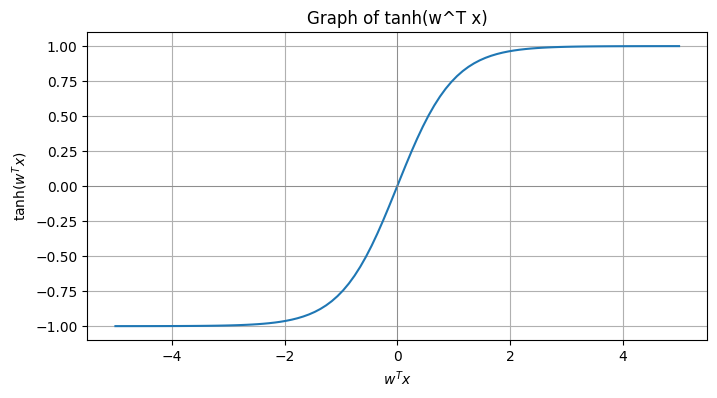

In [15]:
import matplotlib.pyplot as plt

w_x = np.linspace(-5, 5, 100)
tanh_values = np.tanh(w_x)

plt.figure(figsize=(8, 4))
plt.plot(w_x, tanh_values, label='tanh(w^T x)')
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.title('Graph of tanh(w^T x)')
plt.xlabel('$w^T x$')
plt.ylabel('tanh($w^T x$)')
plt.grid(True)
plt.show()


## Part (c)

Directly replacing $h_w(x_i)$ with $\text{tanh}(w^\top x_i)$ in the logistic regression objective function is not straightforward due to the different ranges and properties of the functions. While $h_w(x)$ maps input to the range [0, 1], $\text{tanh}(w^\top x)$ maps it to [-1, 1]. This affects the interpretation of the logistic loss function, which assumes outputs in the range [0, 1] for the probability interpretation.


## Part (d)

Rewrite the optimization problem for logistic regression with labels $\tilde{y}_i \in \{-1, 1\}$ using $\text{tanh}(w^\top x)$:

$$
\text{min w} \quad -\sum_{i=1}^n \left[\frac{1 + \tilde{y}_i}{2} \log\left(\frac{1 + \text{tanh}(w^\top x_i)}{2}\right) + \frac{1 - \tilde{y}_i}{2} \log\left(\frac{1 - \text{tanh}(w^\top x_i)}{2}\right)\right]
$$


## Part (e)

In [16]:
import numpy as np

def gradient_of_loss(y_i, w, x_i):
    tanh_wx = np.tanh(np.dot(w, x_i))
    grad_tanh = 1 - tanh_wx**2
    factor = -((1 + y_i) / (2 * (1 + tanh_wx)) - (1 - y_i) / (2 * (1 - tanh_wx)))
    gradient = factor * grad_tanh * x_i
    return gradient

w = np.array([1, 2])
x_i = np.array([0.5, -0.5])

gradient_y1 = gradient_of_loss(1, w, x_i)
print("Gradient for y_i = 1:", gradient_y1)

gradient_y_neg1 = gradient_of_loss(-1, w, x_i)
print("Gradient for y_i = -1:", gradient_y_neg1)

Gradient for y_i = 1: [-0.73105858  0.73105858]
Gradient for y_i = -1: [ 0.26894142 -0.26894142]


# Problem 3 (T/F)

## Part (a): Perceptrons

### (i)
**TRUE.** The perceptron update rule is designed to adjust the weights to correct the misclassification of the current example. If $x_i$ is misclassified, the weights are updated as follows: $w' = w + y_i x_i$ if $y_i = 1$ and $w' = w - x_i$ if $y_i = -1$. This adjustment is guaranteed to move the decision boundary in a way that corrects the classification of $x_i$ under linear separability conditions.

### (ii)
**TRUE.** The fundamental theorem of perceptron convergence states that if the data is linearly separable, the perceptron algorithm is guaranteed to find a separating hyperplane in a finite number of updates. Thus, it will converge to a model that correctly classifies all training examples without error.

### (iii)
**TRUE.** The prediction of a perceptron is based on the sign of the dot product between the weights and the input features. Multiplying the weight vector by a negative scalar will negate the dot product for any input, thus flipping the sign of the prediction for all inputs.

## Part (b): Logistic Regression

### (i)
**FALSE.** The logistic regression model predicts probabilities, and the decision boundary is where $w^\top x = 0$. At this boundary, $\sigma(w^\top x) = 0.5$, not $0$. Thus, the decision boundary is where the model is uncertain between class labels, not where $w^\top x \geq 0$.

### (ii)
**TRUE.** Stochastic Gradient Descent (SGD) updates the model parameters using only a single data point at a time, which is computationally less expensive per iteration compared to Batch Gradient Descent, which requires computing gradients over the entire dataset.

### (iii)
**TRUE.** When $y = 0$, the logistic loss reduces to $-\log(1 - \sigma(h_w(x)))$, which simplifies to $\log(1 + e^{h_w(x)})$ because $-\log(1 - \sigma(a)) = \log(1 + e^a)$ where $a = h_w(x)$.

### (iv)
**FALSE.** The correct derivative of the sigmoid function $\sigma(a)$ is $\sigma(a)(1-\sigma(a)) = \frac{e^{-a}}{(1+e^{-a})^2}$, which represents how the sigmoid function's slope changes at point $a$.

## Part (c): Linear Regression

### (i)
**FALSE.** A closed-form solution for linear regression is possible if $X^\top X$ is invertible or non-singular, which requires it to be positive semi-definite, not necessarily positive definite. Positive definiteness is not required because we do not need $z^\top (X^\top X) z > 0$ for all non-zero $z$, but rather non-singularity to avoid division by zero in calculations.

### (ii)
**TRUE.** This is the correct expression for the gradient of the $\ell_2$ regularized linear regression loss function. The first term, $2X^\top (Xw - y)$, is the gradient of the least squares loss, and $2\lambda w$ is the gradient of the regularization term, reflecting the increase in penalty as the magnitude of $w$ increases.


# Problem 4: Binary Classification

Please follow our instructions in the same order to solve the binary classification problem.
Please print out the entire results and codes when completed.

In [17]:
#X_train, y_train = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='train')
#X_test, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='t10k')

X_train = np.load('./data/binary_classification/X_train.npy')
y_train = np.load('./data/binary_classification/y_train.npy')
X_test = np.load('./data/binary_classification/X_test.npy')
y_test = np.load('./data/binary_classification/y_test.npy')

print('Train data shape: ', X_train.shape)
print('Train target shape: ', y_train.shape)
print('Test data shape: ',X_test.shape)
print('Test target shape: ',y_test.shape)

Train data shape:  (5000, 784)
Train target shape:  (5000, 1)
Test data shape:  (500, 784)
Test target shape:  (500, 1)


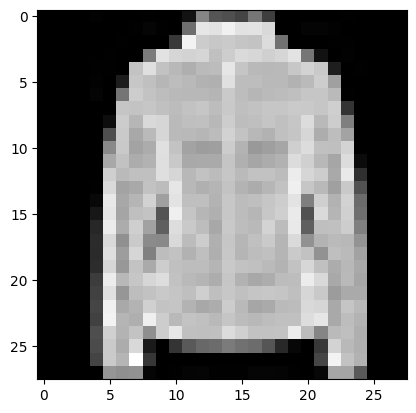

label is Shirt
train data shape:  (5000, 784)
train target shape:  (5000, 1)
test data shape:  (500, 784)
test target shape:  (500, 1)


In [24]:
# PART (a): 
# To Visualize a point in the dataset
index = 11
X = np.array(X_train[index], dtype='uint8')
X = X.reshape((28, 28))
fig = plt.figure()
plt.imshow(X, cmap='gray')
plt.show()
if y_train[index] == 1:
    label = 'Dress'
else:
    label = 'Shirt'
print('label is', label)

# dimensions
print('train data shape: ', X_train.shape)
print('train target shape: ', y_train.shape)
print('test data shape: ',X_test.shape)
print('test target shape: ', y_test.shape)

## Train Perceptron
In the following cells, you will build Perceptron Algorithm.

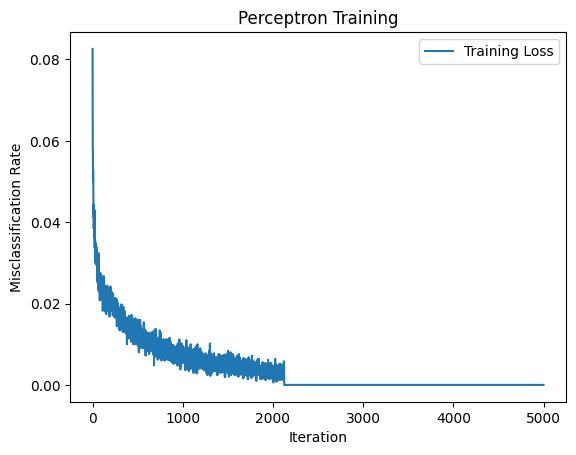

final misclassification rate: 0.00%
weight norm: 659979038983.00
perceptron test error: 50.00%


In [20]:
# PART (b),(c): 
# Implement the perceptron Algorithm and compute the number of mis-classified point
N = X_train.shape[0] # Number of data point train
N_test = X_test.shape[0] # Number of data point test
d = X_train.shape[1] # Number of features
loss_hist = []
W = np.zeros((d+1,1))
X_train_h = np.hstack((np.ones((N,1)), X_train))
X_test_h = np.hstack((np.ones((N_test,1)), X_test))
# ================================================================ #
# YOUR CODE HERE:
# complete the following code to plot both the training and test accuracy in the same plot
# for m range from 1 to N
# ================================================================ #
def perceptron_train(X, y, num_iter):
    n, d = X.shape
    w = np.zeros(d)
    loss_hist = []

    for _ in range(num_iter):
        misclassified = 0
        for i in range(n):
            if y[i] * np.dot(w, X[i]) <= 0:
                w += y[i] * X[i]
                misclassified += 1
        loss_hist.append(misclassified / n)
    return w, loss_hist

# add bias term
X_train_b = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_b = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# train perceptron
w, loss_hist = perceptron_train(X_train_b, y_train, num_iter=X_train.shape[0])

# plot training history
plt.figure()
plt.plot(loss_hist, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Misclassification Rate')
plt.title('Perceptron Training')
plt.legend()
plt.show()

# compute final loss and weight norm
final_loss = loss_hist[-1]
weight_norm = np.linalg.norm(w)**2
print(f'final misclassification rate: {final_loss*100:.2f}%')
print(f'weight norm: {weight_norm:.2f}')

# perceptron test error
def perceptron_predict(X, w):
    return np.sign(X @ w)

y_pred_test = perceptron_predict(X_test_b, w)
test_error = np.mean(y_pred_test != y_test)
print(f'perceptron test error: {test_error*100:.2f}%')
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

## Train Logistic Regression
In the following cells, you will build a logistic regression. You will implement its loss function, then subsequently train it with gradient descent.

In [1]:
from codes.Logistic import Logistic

In [4]:
## PART (f): 
X_train = np.load('./data/binary_classification/X_train.npy')
y_train = np.load('./data/binary_classification/y_train.npy')
X_test = np.load('./data/binary_classification/X_test.npy')
y_test = np.load('./data/binary_classification/y_test.npy')
## Complete loss_and_grad function in Logistic.py file and test your results.
N,d = X_train.shape
X_augmented = np.hstack((np.ones((N, 1)), X_train))  # adding a column of ones
logistic = Logistic(d=d, reg_param=0)
loss, grad = logistic.loss_and_grad(X_augmented,y_train)
print('loss func =',loss)
print('squared norm of gradient =',np.linalg.norm(grad,ord=2)**2)

loss func = 0.6931471805599454
squared norm of gradient = 4123929.35116495


In [ ]:
## PART (g):
## Complete train_LR function in Logisitc.py file
loss_history, w = logistic.train_LR(X_train,y_train, eta=1e-6,batch_size=100, num_iters=5000)
fig = plt.figure()
plt.plot(loss_history)
plt.xlabel('iterations')
plt.ylabel('Loss function')
plt.show()
fig.savefig('./plots/LR_loss_hist.pdf')
print('Weight squared norm',np.linalg.norm(w,ord=2)**2)
print('Final loss',loss_history[-1])

In [ ]:
# PART (h)
# Complete predict function in Logisitc.py file and compute the percentage of mis-classified points
y_pred = logistic.predict(X_test)
test_err = np.sum((y_test!=y_pred))*100/X_test.shape[0]
print(test_err,'%')

In [ ]:
## PART (i): 
Batch = [1, 50 , 100, 200, 300]
test_err = np.zeros((len(Batch),1))
# ================================================================ #
# YOUR CODE HERE:
# Train the Logistic regression for different batch size. Avergae the test error over 10 times
# ================================================================ #
for b_size in Batch:
    errors = []
    for _ in range(50):  # train model 50 times to average test errors
        logistic = Logistic(d=X_train_b.shape[1], reg_param=0)
        _, w_lr = logistic.train_LR(X_train_b, y_train, eta=1e-5, batch_size=b_size, num_iters=int(6000/b_size))
        y_pred = logistic.predict(X_test_b)
        error = np.mean(y_pred != y_test)
        errors.append(error)
    test_err.append(np.mean(errors))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
fig = plt.figure()
plt.plot(Batch,test_err)
plt.xlabel('Batch_size')
plt.ylabel('Test_error')
plt.show()
fig.savefig('./plots/LR_Batch_test.pdf')

In [22]:
# Logistic.py

import numpy as np

class Logistic(object):
    def __init__(self, d=784, reg_param=0):
        """"
        Inputs:
          - d: Number of features
          - regularization parameter reg_param
        Goal:
         - Initialize the weight vector self.w
         - Initialize the  regularization parameter self.reg
        """
        self.reg  = reg_param
        self.dim = [d+1, 1]
        self.w = np.zeros(self.dim)
    def gen_features(self, X):
        """
        Inputs:
         - X: A numpy array of shape (N,d) containing the data.
        Returns:
         - X_out an augmented training data to a feature vector e.g. [1, X].
        """
        N,d = X.shape
        # X_out= np.zeros((N,d+1))
        # ================================================================ #
        # YOUR CODE HERE:
        # IMPLEMENT THE MATRIX X_out=[1, X]
        # ================================================================ #
        X_out = np.hstack((np.ones((N, 1)), X))
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        return X_out  
    def loss_and_grad(self, X, y):
        """
        Inputs:
        - X: N x d array of training data.
        - y: N x 1 labels 
        Returns:
        - loss: a real number represents the loss 
        - grad: a vector of the same dimensions as self.w containing the gradient of the loss with respect to self.w 
        """
        # loss = 0.0
        # grad = np.zeros_like(self.w) 
        N,d = X.shape 
        
        # ================================================================ #
        # YOUR CODE HERE:
        # Calculate the loss function of the logistic regression
        # save loss function in loss
        # Calculate the gradient and save it as grad
        # ================================================================ #

        h = 1 / (1 + np.exp(-X.dot(self.w)))  # sigmoid function
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h)) + self.reg / 2 * np.sum(self.w ** 2)
        grad = X.T.dot(h - y) / N + self.reg * self.w

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        return loss, grad
    
    def train_LR(self, X, y, eta=1e-3, batch_size=1, num_iters=1000) :
        """
        Inputs:
         - X         -- numpy array of shape (N,d), features
         - y         -- numpy array of shape (N,), labels
         - eta       -- float, learning rate
         - num_iters -- integer, maximum number of iterations
        Returns:
         - loss_history: vector containing the loss at each training iteration.
         - self.w: optimal weights 
        """
        loss_history = []
        N,d = X.shape
        for t in np.arange(num_iters):
                # X_batch = None
                # y_batch = None
                # ================================================================ #
                # YOUR CODE HERE:
                # Sample batch_size elements from the training data for use in gradient descent.  
                # After sampling, X_batch should have shape: (batch_size,1), y_batch should have shape: (batch_size,)
                # The indices should be randomly generated to reduce correlations in the dataset.  
                # Use np.random.choice.  It is better to user WITHOUT replacement.
                # ================================================================ #
                indices = np.random.choice(N, batch_size, replace=False)
                X_batch = X[indices]
                y_batch = y[indices]

                # ================================================================ #
                # END YOUR CODE HERE
                # ================================================================ #
                # loss = 0.0
                # grad = np.zeros_like(self.w)
                # ================================================================ #
                # YOUR CODE HERE: 
                # evaluate loss and gradient for batch data
                # save loss as loss and gradient as grad
                # update the weights self.w
                # ================================================================ #
                loss, grad = self.loss_and_grad(X_batch, y_batch)
                self.w -= eta * grad  # update weights

                # ================================================================ #
                # END YOUR CODE HERE
                # ================================================================ #
                loss_history.append(loss)
        return loss_history, self.w
    
    def predict(self, X):
        """
        Inputs:
        - X: N x d array of training data.
        Returns:
        - y_pred: Predicted labelss for the data in X. y_pred is a 1-dimensional
          array of length N.
        """
        # y_pred = np.zeros(X.shape[0]+1)
        # ================================================================ #
        # YOUR CODE HERE:
        # PREDICT THE LABELS OF X 
        # ================================================================ #
        z = X.dot(self.w)  # Compute the linear combination
        probs = 1 / (1 + np.exp(-z))  # Apply the sigmoid function
        y_pred = (probs >= 0.5).astype(int)  # Convert probabilities to 0 or 1        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
        return y_pred

# Problem 5: Linear Regression
Please follow our instructions in the same order to solve the linear regresssion problem.

Please print out the entire results and codes when completed.

In [10]:
def get_data():
    """
    Load the dataset from disk and perform preprocessing to prepare it for the linear regression problem.   
    """
    X_train, y_train = load('./data/regression/regression_train.csv')
    X_test, y_test = load('./data/regression/regression_test.csv')
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test= get_data()  


print('Train data shape: ', X_train.shape)
print('Train target shape: ', y_train.shape)
print('Test data shape: ',X_test.shape)
print('Test target shape: ',y_test.shape)

Train data shape:  (30, 1)
Train target shape:  (30,)
Test data shape:  (30, 1)
Test target shape:  (30,)


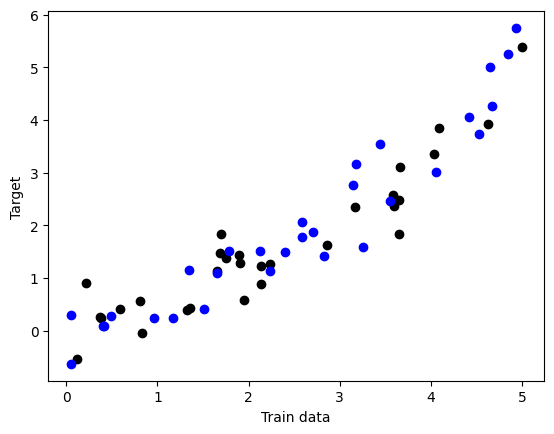

In [11]:
## PART (a): 
## Plot the training and test data ##

plt.plot(X_train, y_train,'o', color='black')
plt.plot(X_test, y_test,'o', color='blue')
plt.xlabel('Train data')
plt.ylabel('Target')
plt.show()

## Training Linear Regression
In the following cells, you will build a linear regression. You will implement its loss function, then subsequently train it with gradient descent. You will choose the learning rate of gradient descent to optimize its classification performance. Finally, you will get the opimal solution using closed form expression.

In [12]:
from codes.Regression import Regression

In [ ]:
## PART (c): 
## Complete loss_and_grad function in Regression.py file and test your results.
regression = Regression(m=1, reg_param=0)
loss, grad = regression.loss_and_grad(X_train,y_train)
print('Loss value',loss)
print('Gradient value',grad)
##

In [ ]:
## PART (d): 
## Complete train_LR function in Regression.py file 
loss_history, w = regression.train_LR(X_train,y_train, eta=1e-3,batch_size=30, num_iters=10000)
plt.plot(loss_history)
plt.xlabel('iterations')
plt.ylabel('Loss function')
plt.show()
print(w)
print('Final loss:',loss_history[-1])

In [ ]:
## PART (d) (Different Learning Rates):
from numpy.linalg import norm
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
test_err = np.zeros((len(lrs),1))
# ================================================================ #
# YOUR CODE HERE:
# Train the Logistic regression for different learning rates and average the test error over 10 times
# ================================================================ #
error_trials = 10
for i, lr in enumerate(lrs):
    errors = []
    for trial in range(error_trials):
        regression = Regression(m=1, reg_param=0)
        regression.train_LR(X_train, y_train, eta=lr, batch_size=30, num_iters=1000)
        y_pred = regression.predict(X_test)
        error = np.mean((y_pred - y_test)**2)
        errors.append(error)
    test_err[i] = np.mean(errors)
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
fig = plt.figure()
plt.plot(lrs,test_err)
plt.xlabel('Learning Rate')
plt.ylabel('Test_error')
plt.show()
fig.savefig('./plots/LR_Batch_test.pdf')

In [ ]:
## PART (e): 
## Complete closed_form function in Regression.py file
loss_2, w_2 = regression.closed_form(X_train, y_train)
print('Optimal solution loss',loss_2)
print('Optimal solution gradient',w_2)

In [ ]:
## PART (g): 
train_loss=np.zeros((10,1))
test_loss=np.zeros((10,1))
# ================================================================ #
# YOUR CODE HERE:
# complete the following code to plot both the training and test loss in the same plot
# for m range from 1 to 10
# ================================================================ #
for m in range(11):
    regression = Regression(m=m, reg_param=0)  # Initialize regression with degree m
    regression.train_LR(X_train, y_train, eta=1e-3, batch_size=30, num_iters=10000)  # Train model
    y_train_pred = regression.predict(X_train)  # Predict on training data
    y_test_pred = regression.predict(X_test)  # Predict on test data

    # Calculate mean squared error for training and test sets
    train_loss[m] = np.mean((y_train - y_train_pred)**2)
    test_loss[m] = np.mean((y_test - y_test_pred)**2)
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
plt.plot(train_loss)
plt.plot(test_loss, color='black')
plt.show()

In [ ]:
#PART (i): 
train_loss=np.zeros((10,1))
test_loss=np.zeros((10,1))
# ================================================================ #
# YOUR CODE HERE:
# complete the following code to plot both the training and test loss in the same plot
# for m range from 1 to 10
# ================================================================ #
lambdas = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]  # regularization strengths

for i, lam in enumerate(lambdas):
    regression = Regression(m=10, reg_param=lam)  # Initialize regression with m=10 and current lambda
    regression.train_LR(X_train, y_train, eta=1e-3, batch_size=30, num_iters=10000)  # Train model
    y_train_pred = regression.predict(X_train)  # Predict on training data
    y_test_pred = regression.predict(X_test)  # Predict on test data

    # Calculate mean squared error for training and test sets
    train_loss[i] = np.mean((y_train - y_train_pred)**2)
    test_loss[i] = np.mean((y_test - y_test_pred)**2)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

plt.plot(train_loss)
plt.plot(test_loss, color='black')
plt.show()

In [ ]:
# Regression.py

import numpy as np

class Regression(object):
    def __init__(self, m=1, reg_param=0):
        """"
        Inputs:
          - m Polynomial degree
          - regularization parameter reg_param
        Goal:
         - Initialize the weight vector self.w
         - Initialize the polynomial degree self.m
         - Initialize the  regularization parameter self.reg
        """
        self.m = m
        self.reg  = reg_param
        self.dim = [m+1 , 1]
        self.w = np.zeros(self.dim)
    def gen_poly_features(self, X):
        """
        Inputs:
         - X: A numpy array of shape (N,1) containing the data.
        Returns:
         - X_out an augmented training data to an mth degree feature vector e.g. [1, X, X^2, ..., X^m].
        """
        N,d = X.shape
        m = self.m
        X_out= np.zeros((N,m+1))
        if m==1:
            # ================================================================ #
            # YOUR CODE HERE:
            # IMPLEMENT THE MATRIX X_out=[1, X]
            # ================================================================ #
            X_out[:, 1] = X[:, 0]
            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #
        else:
            # ================================================================ #
            # YOUR CODE HERE:
            # IMPLEMENT THE MATRIX X_out=[1, X, x^2,....,X^m]
            # ================================================================ #
            for i in range(1, m+1):
                X_out[:, i] = X[:, 0]**i            
            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #
        return X_out  
    
    def loss_and_grad(self, X, y):
        """
        Inputs:
        - X: N x d array of training data.
        - y: N x 1 targets 
        Returns:
        - loss: a real number represents the loss 
        - grad: a vector of the same dimensions as self.w containing the gradient of the loss with respect to self.w 
        """
        loss = 0.0
        grad = np.zeros_like(self.w) 
        m = self.m
        N,d = X.shape 
        if m==1:
            # ================================================================ #
            # YOUR CODE HERE:
            # Calculate the loss function of the linear regression
            # save loss function in loss
            # Calculate the gradient and save it as grad
            #
            # ================================================================ #
            y_pred = X.dot(self.w)
            residuals = y_pred - y
            loss = np.mean(residuals**2)
            grad = 2 * X.T.dot(residuals) / N
            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #
        else:
            # ================================================================ #
            # YOUR CODE HERE:
            # Calculate the loss function of the polynomial regression with order m
            # ================================================================ #
            y_pred = X.dot(self.w)
            residuals = y_pred - y
            loss = np.mean(residuals**2) + self.reg * np.sum(self.w[1:]**2) / 2
            grad = 2 * X.T.dot(residuals) / N + self.reg * np.r_[0, self.w[1:]]
            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #
        return loss, grad
    
    def train_LR(self, X, y, eta=1e-3, batch_size=30, num_iters=1000) :
        """
        Finds the coefficients of a {d-1}^th degree polynomial
        that fits the data using least squares batch gradient descent.

        Inputs:
         - X         -- numpy array of shape (N,1), features
         - y         -- numpy array of shape (N,), targets
         - eta       -- float, learning rate
         - num_iters -- integer, maximum number of iterations
         
        Returns:
         - loss_history: vector containing the loss at each training iteration.
         - self.w: optimal weights 
        """
        loss_history = []
        N,d = X.shape
        for t in np.arange(num_iters):
                X_batch = None
                y_batch = None
                # ================================================================ #
                # YOUR CODE HERE:
                # Sample batch_size elements from the training data for use in gradient descent.  
                # After sampling, X_batch should have shape: (batch_size,1), y_batch should have shape: (batch_size,)
                # The indices should be randomly generated to reduce correlations in the dataset.  
                # Use np.random.choice.  It is better to user WITHOUT replacement.
                # ================================================================ #
                indices = np.random.choice(N, batch_size, replace=False)
                X_batch = X[indices]
                y_batch = y[indices]
                # ================================================================ #
                # END YOUR CODE HERE
                # ================================================================ #
                loss = 0.0
                grad = np.zeros_like(self.w)
                # ================================================================ #
                # YOUR CODE HERE: 
                # evaluate loss and gradient for batch data
                # save loss as loss and gradient as grad
                # update the weights self.w
                # ================================================================ #
                loss, grad = self.loss_and_grad(X_batch, y_batch)
                self.w -= eta * grad
                # ================================================================ #
                # END YOUR CODE HERE
                # ================================================================ #
                loss_history.append(loss)
        return loss_history, self.w
    def closed_form(self, X, y):
        """
        Inputs:
        - X: N x 1 array of training data.
        - y: N x 1 array of targets
        Returns:
        - self.w: optimal weights 
        """
        m = self.m
        N,d = X.shape
        if m==1:
            # ================================================================ #
            # YOUR CODE HERE:
            # obtain the optimal weights from the closed form solution 
            # ================================================================ #
            XTX = X.T.dot(X)
            XTy = X.T.dot(y)
            self.w = np.linalg.inv(XTX).dot(XTy)
            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #
        else:
            # ================================================================ #
            # YOUR CODE HERE:
            # IMPLEMENT THE MATRIX X_out=[1, X, x^2,....,X^m]
            # ================================================================ #
            XTX = X.T.dot(X)
            XTy = X.T.dot(y)
            self.w = np.linalg.inv(XTX + self.reg * np.eye(X.shape[1])).dot(XTy)
            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #
        return self.w
    
    
    def predict(self, X):
        """
        Inputs:
        - X: N x 1 array of training data.
        Returns:
        - y_pred: Predicted targets for the data in X. y_pred is a 1-dimensional
          array of length N.
        """
        y_pred = np.zeros(X.shape[0])
        m = self.m
        if m==1:
            # ================================================================ #
            # YOUR CODE HERE:
            # PREDICT THE TARGETS OF X 
            # ================================================================ #
            y_pred = X.dot(self.w)
            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #
        else:
            # ================================================================ #
            # YOUR CODE HERE:
            # IMPLEMENT THE MATRIX X_out=[1, X, x^2,....,X^m]
            # ================================================================ #
            y_pred = X.dot(self.w)          
            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #
        return y_pred